# 3. Image-Similar-FCNN-Binary
For landmark-recognition-2019 algorithm validation

## Run name

In [1]:
import time
project_name = 'Google-LandMark-Rec2019'
step_name = '3-Image-Similar-FCNN-Binary'
time_str = time.strftime("%Y%m%d-%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: Google-LandMark-Rec2019_3-Image-Similar-FCNN-Binary_20190511-164020


## Important params

In [2]:
import multiprocessing

cpu_amount = multiprocessing.cpu_count()
print('cpu_amount: ', cpu_amount)

batch_size = 16
print(batch_size)

cpu_amount:  4
16


## Import PKGs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display

import os
import sys
import gc
import math
import shutil
import zipfile
import pickle
import h5py
import random

# from tqdm import tqdm
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
import keras
from keras.utils import Sequence
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.preprocessing.image import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [5]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)

KTF.set_session(session )

## Project folders

In [6]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')

org_train_folder = os.path.join(input_folder, 'org_train')
org_test_folder = os.path.join(input_folder, 'org_test')
train_folder = os.path.join(input_folder, 'data_train')
val_folder = os.path.join(input_folder, 'data_val')
test_folder = os.path.join(input_folder, 'data_test')
test_sub_folder = os.path.join(test_folder, 'test')

vgg16_feature_file = os.path.join(feature_folder, 'feature_wrapper_171023.h5')
train_csv_file = os.path.join(input_folder, 'train.csv')
test_csv_file = os.path.join(input_folder, 'test.csv')
sample_submission_folder = os.path.join(input_folder, 'sample_submission.csv')
print(vgg16_feature_file)
print(train_csv_file)
print(test_csv_file)
print(sample_submission_folder)

/data/landmark-recognition-2019/feature/feature_wrapper_171023.h5
/data/landmark-recognition-2019/input/train.csv
/data/landmark-recognition-2019/input/test.csv
/data/landmark-recognition-2019/input/sample_submission.csv


## Functions

In [7]:
def pickle_dump(data, file):
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def pickle_load(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data

a = list(range(10))
print(a)
demo_file = os.path.join(os.getcwd(), 'temp', 'pickle_demo.pkl')
print(demo_file)
pickle_dump(a, demo_file)
new_a = pickle_load(demo_file)
print(new_a)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
/data/landmark-recognition-2019/temp/pickle_demo.pkl
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
%%time

def get_whole_classes_label(class_indices_data, item_classes_data):
    indices2class = {}
    for i, key in enumerate(class_indices_data.keys()):
#         print(key, class_indices_data[key])
        indices2class[class_indices_data[key]] = key
#         if i >= 5:
#             break
#     for i, key in enumerate(class_indices_data.keys()):
#         print(key, class_indices_data[key], '-->', class_indices_data[key], indices2class[class_indices_data[key]])
#         if i >= 10:
#             break
    print(item_classes_data.shape)
    whole_classes_data = np.zeros(item_classes_data.shape)
    for i, class_index in enumerate(item_classes_data):
        whole_classes_data[i] = indices2class[class_index]
#         print(i, class_index, '-->', indices2class[class_index])
#         if i >= 10:
#             break
    return whole_classes_data
# get_whole_classes_label(class_indices_train, item_classes_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


## Load feature

In [9]:
!ls ./feature -hl

total 8.6G
-rw-r--r-- 1 ubuntu ubuntu 830K May  3 12:19 feature_VGG16_data_val_171023.h5
-rw-r--r-- 1 root   root     20 May 11 04:24 feature_VGG19_data_test_171023_class_indices.pkl
-rw-r--r-- 1 root   root   222M May 11 04:24 feature_VGG19_data_test_171023.h5
-rw-r--r-- 1 ubuntu ubuntu 631K May  6 17:05 feature_VGG19_data_train_00_171023_class_indices.pkl
-rw-r--r-- 1 ubuntu ubuntu  99M May  6 17:05 feature_VGG19_data_train_00_171023.h5
-rw-r--r-- 1 ubuntu ubuntu 634K May  6 17:30 feature_VGG19_data_train_01_171023_class_indices.pkl
-rw-r--r-- 1 ubuntu ubuntu  99M May  6 17:30 feature_VGG19_data_train_01_171023.h5
-rw-r--r-- 1 ubuntu ubuntu 634K May  6 18:01 feature_VGG19_data_train_02_171023_class_indices.pkl
-rw-r--r-- 1 ubuntu ubuntu  99M May  6 18:01 feature_VGG19_data_train_02_171023.h5
-rw-r--r-- 1 ubuntu ubuntu 631K May  6 18:33 feature_VGG19_data_train_03_171023_class_indices.pkl
-rw-r--r-- 1 ubuntu ubuntu  99M May  6 18:33 feature_VGG19_data_train_03_171023.h5
-rw-r--r-- 1 u

In [10]:
def load_feature(data_set_name, model_name, date_str, feature_amount):
#     data_set_name = 'train'
#     model_name = 'VGG19'
#     date_str = '171023'
    x_data_arr = []
    classes_data_arr = []
    index_data_arr = []
    for i in range(feature_amount):
        folder_name = 'data_%s_%02d' % (data_set_name, i)
        class_indices_file = os.path.join(cwd, 'feature', 'feature_{0}_{1}_{2}_class_indices.pkl'.format(model_name, folder_name, date_str))
        h5py_file_name = os.path.join(cwd, 'feature', 'feature_{0}_{1}_{2}.h5'.format(model_name, folder_name, date_str))
        if not os.path.exists(class_indices_file):
            print('File not exists', class_indices_file)
            continue
        if not os.path.exists(h5py_file_name):
            print('File not exists', h5py_file_name)
            continue
        print(class_indices_file)
        print(h5py_file_name)
        class_indices_data = pickle_load(class_indices_file)
        print(len(class_indices_data))

        with h5py.File(h5py_file_name, 'r') as h:
            item_x_data = np.array(h['x_data_%s_%02d' % (data_set_name, i)])
            item_classes_data = np.array(h['classes_data_%s_%02d' % (data_set_name, i)])
            item_index_data = np.array(h['index_data_%s_%02d' % (data_set_name, i)])
        print(item_x_data.shape)
        x_data_arr.append(item_x_data)
        item_y_data = get_whole_classes_label(class_indices_data, item_classes_data)
        print(item_y_data.shape, item_y_data[:10])
        classes_data_arr.append(item_y_data)
        index_data_arr.append(item_index_data)
    x_data = np.concatenate(x_data_arr, axis=0)
    y_data = np.concatenate(classes_data_arr, axis=0)
    idx_data = np.concatenate(index_data_arr, axis=0)
    print('*' * 60)
    print(x_data.shape)
    print(y_data.shape)
    print(idx_data.shape)
    return x_data, y_data, idx_data


In [11]:
x_train, y_train, idx_train = load_feature('train', 'VGG19', '171023', 40)

/data/landmark-recognition-2019/feature/feature_VGG19_data_train_00_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_00_171023.h5
34008
(50000, 512)
(50000,)
(50000,) [ 0.  3. 24. 25. 27. 27. 27. 27. 48. 52.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_01_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_01_171023.h5
34214
(50000, 512)
(50000,)
(50000,) [ 1. 12. 27. 27. 27. 27. 27. 27. 27. 37.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_02_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_02_171023.h5
34203
(50000, 512)
(50000,)
(50000,) [12. 17. 18. 27. 27. 27. 27. 27. 30. 35.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_03_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_03_171023.h5
34051
(50000, 512)
(50000,)
(50000,) [ 1.  5.  9. 10. 12. 27. 27. 27. 27. 27.]


(50000,) [ 3.  3. 11. 12. 12. 17. 20. 20. 22. 26.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_33_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_33_171023.h5
34164
(50000, 512)
(50000,)
(50000,) [ 1.  3. 10. 12. 16. 22. 26. 27. 27. 27.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_34_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_34_171023.h5
34351
(50000, 512)
(50000,)
(50000,) [ 1.  2.  7. 12. 27. 27. 27. 27. 27. 27.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_35_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_35_171023.h5
34228
(50000, 512)
(50000,)
(50000,) [ 1. 13. 27. 27. 27. 27. 27. 27. 36. 37.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_36_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_train_36_171023.h5
34040
(50000, 512)
(50000,)


In [12]:
x_val, y_val, idx_val = load_feature('val', 'VGG19', '171023', 4)

/data/landmark-recognition-2019/feature/feature_VGG19_data_val_00_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_00_171023.h5
34160
(50000, 512)
(50000,)
(50000,) [ 1. 12. 20. 27. 27. 27. 27. 27. 27. 32.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_01_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_01_171023.h5
34196
(50000, 512)
(50000,)
(50000,) [ 9. 11. 24. 27. 27. 27. 27. 27. 27. 27.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_02_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_02_171023.h5
34264
(50000, 512)
(50000,)
(50000,) [ 1. 10. 11. 12. 27. 27. 27. 27. 27. 27.]
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_03_171023_class_indices.pkl
/data/landmark-recognition-2019/feature/feature_VGG19_data_val_03_171023.h5
34155
(50000, 512)
(50000,)
(50000,) [ 1.  2. 10. 11. 13. 24. 27. 27. 27. 27.]
****************

## ImageSequence

In [13]:
class ImageSequence(Sequence):
    def __init__(self, x, y, batch_size, times_for_1_image, positive_rate):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.times_for_1_image = times_for_1_image
        self.positive_rate = positive_rate
        
        self.len_x = self.x.shape[0]
        self.index = list(range(self.len_x))
        self.group = {}
        classes = list(set(self.y))
        classes.sort()
        self.classes = [item for item in classes]
        for c in self.classes:
            self.group[c] = []
        for i, y_i in enumerate(self.y):
            temp_arr = self.group[y_i]
            temp_arr.append(i)
            self.group[y_i] = temp_arr
        
    def __len__(self):
        # times_for_1_image: the times to train one image
        # 2: positive example and negative example
        return self.times_for_1_image * 2 * (math.ceil(self.len_x/self.batch_size))
    def __getitem__(self, idx):
        batch_main_x = np.zeros((self.batch_size, self.x.shape[1]))
        batch_libary_x = np.zeros((self.batch_size, self.x.shape[1]))
        batch_x = {}
        batch_y = [] # 0 or 1
        new_class = [item for item in self.classes]
        # is_positive = random.random() < self.positive_rate
        for i in range(self.batch_size):
            # prepare main image
            item_main_image_idx = random.choice(self.index) # random choice one image from all train images
            item_main_image_y = self.y[item_main_image_idx]
            
            # prepare libary image
            is_positive = random.random() < self.positive_rate
            if is_positive: # chioce a positive image as libary_x
                # choice one image from itself group
                item_libary_image_idx = random.choice(self.group[item_main_image_y]) # don't exclude item_main_image_idx, so it could choice a idx same to item_main_image_idx.
            else: # chioce a negative image as libary_x
                # choice group
                # new_class = copy.deepcopy(self.classes) # this method make generator slow
                if item_main_image_y in new_class:
                    new_class.remove(item_main_image_y)
                item_libary_image_group_num = random.choice(new_class)
                # choice one image from group
                item_libary_image_idx = random.choice(self.group[item_libary_image_group_num])
            # add item data to batch
            batch_main_x[i] = self.x[item_main_image_idx]
            batch_libary_x[i] = self.x[item_libary_image_idx]
            batch_y.append(int(is_positive))
        # concatenate array to np.array
        batch_x = {
            'main_input': batch_main_x,
            'library_input': batch_libary_x
        }
        batch_y = np.array(batch_y)
        return batch_x, batch_y

demo_sequence = ImageSequence(x_train[:200], y_train[:200], 128, 3, 0.1)
print(len(demo_sequence))
print(type(demo_sequence))

batch_index = 0
demo_batch = demo_sequence[batch_index]
demo_batch_x = demo_batch[0]
demo_batch_y = demo_batch[1]
print(type(demo_batch_x))
print(type(demo_batch_y))

demo_main_input = demo_batch_x['main_input']
demo_library_input = demo_batch_x['library_input']
print(demo_main_input.shape)
print(demo_library_input.shape)
print(demo_batch_y.shape)

# print(demo_main_input[0])
print(demo_batch_y)

12
<class '__main__.ImageSequence'>
<class 'dict'>
<class 'numpy.ndarray'>
(128, 512)
(128, 512)
(128,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


In [14]:
train_sequence = ImageSequence(x_train, y_train, batch_size, 3, 0.5)

In [15]:
val_sequence = ImageSequence(x_val, y_val, batch_size, 3, 0.5)

## Model

In [16]:
main_input = Input((x_train.shape[1],), dtype='float32', name='main_input')
library_input = Input((x_train.shape[1],), dtype='float32', name='library_input')

x = keras.layers.concatenate([main_input, library_input])
# x = Dense(x_train.shape[1]*2, activation='relu')(x)
x = Reshape((x_train.shape[1]*2, 1))(x)
x = BatchNormalization()(x)
x = Conv1D(2, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
# x = Conv1D(4, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
# x = Conv1D(8, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
# x = Conv1D(8, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
# x = Conv1D(4, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
x = Conv1D(2, 1, input_shape=(x_train.shape[1]*2, 1), activation='relu')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
# x = Dropout(0.2)(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[main_input, library_input], outputs=[output])
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 512)          0                                            
__________________________________________________________________________________________________
library_input (InputLayer)      (None, 512)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1024)         0           main_input[0][0]                 
                                                                 library_input[0][0]              
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1024, 1)      0           concatenate_1[0][0]              
__________

In [18]:
hist = model.fit_generator(
    train_sequence, 
    steps_per_epoch=800, 
    epochs=1500, 
    verbose=1, 
    callbacks=None, 
    validation_data=val_sequence, 
    validation_steps=100, 
    class_weight=None, 
    max_queue_size=batch_size*16, 
    workers=cpu_amount, 
    use_multiprocessing=True, 
    shuffle=False, 
    initial_epoch=0
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1500
800/800 [==============================] - 24s 31ms/step - loss: 0.7221 - acc: 0.5098 - val_loss: 0.7001 - val_acc: 0.5437
Epoch 2/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.6938 - acc: 0.5535 - val_loss: 0.6784 - val_acc: 0.5781
Epoch 3/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.6800 - acc: 0.5749 - val_loss: 0.6412 - val_acc: 0.6312
Epoch 4/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.6710 - acc: 0.5898 - val_loss: 0.6249 - val_acc: 0.6550
Epoch 5/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.6577 - acc: 0.6098 - val_loss: 0.6310 - val_acc: 0.6388
Epoch 6/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.6482 - acc: 0.6153 - val_loss: 0.6220 - val_acc: 0.6569
Epoch 7/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.6411 - acc: 0.6248 - val_loss: 0.6050 - val_acc: 0.6719


Epoch 59/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.5252 - acc: 0.7375 - val_loss: 0.4713 - val_acc: 0.7719
Epoch 60/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.5274 - acc: 0.7311 - val_loss: 0.4694 - val_acc: 0.7662
Epoch 61/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.5219 - acc: 0.7376 - val_loss: 0.4631 - val_acc: 0.7762
Epoch 62/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.5226 - acc: 0.7363 - val_loss: 0.4761 - val_acc: 0.7581
Epoch 63/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.5221 - acc: 0.7351 - val_loss: 0.4695 - val_acc: 0.7656
Epoch 64/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.5330 - acc: 0.7327 - val_loss: 0.4528 - val_acc: 0.7788
Epoch 65/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.5251 - acc: 0.7389 - val_loss: 0.4554 - val_acc: 0.7819
Epoch 66/1500
800/800 [==================

800/800 [==============================] - 21s 27ms/step - loss: 0.4801 - acc: 0.7668 - val_loss: 0.3942 - val_acc: 0.8150
Epoch 178/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4775 - acc: 0.7625 - val_loss: 0.4284 - val_acc: 0.7806
Epoch 179/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4743 - acc: 0.7653 - val_loss: 0.4270 - val_acc: 0.7987
Epoch 180/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4741 - acc: 0.7696 - val_loss: 0.4072 - val_acc: 0.8044
Epoch 181/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4863 - acc: 0.7623 - val_loss: 0.4043 - val_acc: 0.8069
Epoch 182/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4801 - acc: 0.7641 - val_loss: 0.4063 - val_acc: 0.7987
Epoch 183/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4831 - acc: 0.7642 - val_loss: 0.4153 - val_acc: 0.7956
Epoch 184/1500
800/800 [=========================

800/800 [==============================] - 21s 27ms/step - loss: 0.4629 - acc: 0.7751 - val_loss: 0.3745 - val_acc: 0.8181
Epoch 296/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4604 - acc: 0.7751 - val_loss: 0.3959 - val_acc: 0.8025
Epoch 297/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4615 - acc: 0.7763 - val_loss: 0.3743 - val_acc: 0.8131
Epoch 298/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4570 - acc: 0.7753 - val_loss: 0.3836 - val_acc: 0.8094
Epoch 299/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4591 - acc: 0.7787 - val_loss: 0.3902 - val_acc: 0.8169
Epoch 300/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4639 - acc: 0.7744 - val_loss: 0.3976 - val_acc: 0.8031
Epoch 301/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4602 - acc: 0.7765 - val_loss: 0.4069 - val_acc: 0.7919
Epoch 302/1500
800/800 [=========================

800/800 [==============================] - 21s 26ms/step - loss: 0.4501 - acc: 0.7832 - val_loss: 0.3714 - val_acc: 0.8294
Epoch 414/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4542 - acc: 0.7780 - val_loss: 0.3757 - val_acc: 0.8125
Epoch 415/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4572 - acc: 0.7787 - val_loss: 0.3965 - val_acc: 0.8013
Epoch 416/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4496 - acc: 0.7836 - val_loss: 0.3999 - val_acc: 0.8087
Epoch 417/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4540 - acc: 0.7805 - val_loss: 0.3877 - val_acc: 0.8106
Epoch 418/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4442 - acc: 0.7870 - val_loss: 0.3707 - val_acc: 0.8163
Epoch 419/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4549 - acc: 0.7778 - val_loss: 0.3472 - val_acc: 0.8387
Epoch 420/1500
800/800 [=========================

800/800 [==============================] - 21s 26ms/step - loss: 0.4503 - acc: 0.7837 - val_loss: 0.3934 - val_acc: 0.8106
Epoch 532/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4517 - acc: 0.7784 - val_loss: 0.3678 - val_acc: 0.8319
Epoch 533/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4452 - acc: 0.7834 - val_loss: 0.3572 - val_acc: 0.8344
Epoch 534/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4543 - acc: 0.7760 - val_loss: 0.4037 - val_acc: 0.8050
Epoch 535/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4385 - acc: 0.7907 - val_loss: 0.3757 - val_acc: 0.8219
Epoch 536/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4519 - acc: 0.7813 - val_loss: 0.3723 - val_acc: 0.8187
Epoch 537/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4356 - acc: 0.7922 - val_loss: 0.3815 - val_acc: 0.8131
Epoch 538/1500
800/800 [=========================

800/800 [==============================] - 22s 27ms/step - loss: 0.4422 - acc: 0.7872 - val_loss: 0.3600 - val_acc: 0.8244
Epoch 650/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4418 - acc: 0.7875 - val_loss: 0.3747 - val_acc: 0.8175
Epoch 651/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4424 - acc: 0.7903 - val_loss: 0.3693 - val_acc: 0.8281
Epoch 652/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4456 - acc: 0.7863 - val_loss: 0.3999 - val_acc: 0.8056
Epoch 653/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4426 - acc: 0.7904 - val_loss: 0.4021 - val_acc: 0.7981
Epoch 654/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4454 - acc: 0.7818 - val_loss: 0.3642 - val_acc: 0.8287
Epoch 655/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4356 - acc: 0.7901 - val_loss: 0.3702 - val_acc: 0.8313
Epoch 656/1500
800/800 [=========================

Epoch 767/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4262 - acc: 0.7987 - val_loss: 0.3745 - val_acc: 0.8175
Epoch 768/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4366 - acc: 0.7865 - val_loss: 0.3667 - val_acc: 0.8269
Epoch 769/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4332 - acc: 0.7943 - val_loss: 0.3655 - val_acc: 0.8187
Epoch 770/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4403 - acc: 0.7879 - val_loss: 0.3692 - val_acc: 0.8181
Epoch 771/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4422 - acc: 0.7900 - val_loss: 0.3785 - val_acc: 0.8175
Epoch 772/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4383 - acc: 0.7871 - val_loss: 0.3820 - val_acc: 0.8169
Epoch 773/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4326 - acc: 0.7916 - val_loss: 0.3568 - val_acc: 0.8350
Epoch 774/1500
800/800 [==========

800/800 [==============================] - 21s 26ms/step - loss: 0.4313 - acc: 0.7921 - val_loss: 0.3556 - val_acc: 0.8306
Epoch 886/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4375 - acc: 0.7875 - val_loss: 0.3641 - val_acc: 0.8250
Epoch 887/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4299 - acc: 0.7955 - val_loss: 0.3633 - val_acc: 0.8194
Epoch 888/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4387 - acc: 0.7892 - val_loss: 0.3749 - val_acc: 0.8131
Epoch 889/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4392 - acc: 0.7884 - val_loss: 0.3685 - val_acc: 0.8256
Epoch 890/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4339 - acc: 0.7927 - val_loss: 0.3760 - val_acc: 0.8094
Epoch 891/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4337 - acc: 0.7916 - val_loss: 0.3519 - val_acc: 0.8344
Epoch 892/1500
800/800 [=========================

Epoch 944/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4403 - acc: 0.7884 - val_loss: 0.3825 - val_acc: 0.8050
Epoch 945/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4349 - acc: 0.7935 - val_loss: 0.3306 - val_acc: 0.8431
Epoch 946/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4281 - acc: 0.7973 - val_loss: 0.3514 - val_acc: 0.8331
Epoch 947/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4387 - acc: 0.7902 - val_loss: 0.3651 - val_acc: 0.8325
Epoch 948/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4419 - acc: 0.7857 - val_loss: 0.3686 - val_acc: 0.8175
Epoch 949/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4383 - acc: 0.7887 - val_loss: 0.3628 - val_acc: 0.8269
Epoch 950/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4326 - acc: 0.7954 - val_loss: 0.3575 - val_acc: 0.8256
Epoch 951/1500
800/800 [==========

800/800 [==============================] - 22s 27ms/step - loss: 0.4321 - acc: 0.7939 - val_loss: 0.3835 - val_acc: 0.8081
Epoch 1063/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4313 - acc: 0.7918 - val_loss: 0.3890 - val_acc: 0.8037
Epoch 1064/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4260 - acc: 0.8019 - val_loss: 0.3539 - val_acc: 0.8331
Epoch 1065/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4364 - acc: 0.7933 - val_loss: 0.3580 - val_acc: 0.8294
Epoch 1066/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4259 - acc: 0.7917 - val_loss: 0.3656 - val_acc: 0.8187
Epoch 1067/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4293 - acc: 0.7936 - val_loss: 0.3778 - val_acc: 0.8256
Epoch 1068/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4307 - acc: 0.7946 - val_loss: 0.3689 - val_acc: 0.8263
Epoch 1069/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4228 - acc: 0.7977 - val_loss: 0.3682 - val_acc: 0.8163
Epoch 1122/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4319 - acc: 0.7912 - val_loss: 0.3679 - val_acc: 0.8175
Epoch 1123/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4208 - acc: 0.8007 - val_loss: 0.3517 - val_acc: 0.8331
Epoch 1124/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4253 - acc: 0.7984 - val_loss: 0.3806 - val_acc: 0.8225
Epoch 1125/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4367 - acc: 0.7941 - val_loss: 0.3744 - val_acc: 0.8263
Epoch 1126/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4291 - acc: 0.7980 - val_loss: 0.3883 - val_acc: 0.8100
Epoch 1127/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4350 - acc: 0.7953 - val_loss: 0.3680 - val_acc: 0.8219
Epoch 1128/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4327 - acc: 0.7952 - val_loss: 0.3481 - val_acc: 0.8331
Epoch 1181/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4349 - acc: 0.7918 - val_loss: 0.3777 - val_acc: 0.8113
Epoch 1182/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4288 - acc: 0.7927 - val_loss: 0.3692 - val_acc: 0.8256
Epoch 1183/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4209 - acc: 0.8001 - val_loss: 0.3599 - val_acc: 0.8281
Epoch 1184/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4371 - acc: 0.7910 - val_loss: 0.3633 - val_acc: 0.8200
Epoch 1185/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4276 - acc: 0.7991 - val_loss: 0.3604 - val_acc: 0.8281
Epoch 1186/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4265 - acc: 0.7994 - val_loss: 0.3743 - val_acc: 0.8213
Epoch 1187/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4236 - acc: 0.7980 - val_loss: 0.3571 - val_acc: 0.8250
Epoch 1240/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4278 - acc: 0.7944 - val_loss: 0.3698 - val_acc: 0.8187
Epoch 1241/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4186 - acc: 0.7998 - val_loss: 0.3412 - val_acc: 0.8337
Epoch 1242/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4383 - acc: 0.7880 - val_loss: 0.3680 - val_acc: 0.8137
Epoch 1243/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4225 - acc: 0.8027 - val_loss: 0.3728 - val_acc: 0.8187
Epoch 1244/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4332 - acc: 0.7957 - val_loss: 0.3625 - val_acc: 0.8369
Epoch 1245/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4282 - acc: 0.7942 - val_loss: 0.3646 - val_acc: 0.8237
Epoch 1246/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4224 - acc: 0.8013 - val_loss: 0.3598 - val_acc: 0.8325
Epoch 1299/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4271 - acc: 0.7991 - val_loss: 0.3640 - val_acc: 0.8225
Epoch 1300/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4321 - acc: 0.7947 - val_loss: 0.3607 - val_acc: 0.8313
Epoch 1301/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4274 - acc: 0.7926 - val_loss: 0.3762 - val_acc: 0.8175
Epoch 1302/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4254 - acc: 0.7960 - val_loss: 0.3717 - val_acc: 0.8106
Epoch 1303/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4282 - acc: 0.7963 - val_loss: 0.3534 - val_acc: 0.8313
Epoch 1304/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4255 - acc: 0.7973 - val_loss: 0.3639 - val_acc: 0.8300
Epoch 1305/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4298 - acc: 0.7957 - val_loss: 0.3706 - val_acc: 0.8150
Epoch 1358/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4326 - acc: 0.7980 - val_loss: 0.3552 - val_acc: 0.8263
Epoch 1359/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4257 - acc: 0.7927 - val_loss: 0.3516 - val_acc: 0.8319
Epoch 1360/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4264 - acc: 0.7939 - val_loss: 0.3568 - val_acc: 0.8369
Epoch 1361/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4279 - acc: 0.7975 - val_loss: 0.3610 - val_acc: 0.8275
Epoch 1362/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4221 - acc: 0.8000 - val_loss: 0.3435 - val_acc: 0.8506
Epoch 1363/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4271 - acc: 0.7988 - val_loss: 0.3699 - val_acc: 0.8125
Epoch 1364/1500
800/800 [==================

800/800 [==============================] - 21s 27ms/step - loss: 0.4283 - acc: 0.7970 - val_loss: 0.3660 - val_acc: 0.8225
Epoch 1417/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4232 - acc: 0.7984 - val_loss: 0.3660 - val_acc: 0.8206
Epoch 1418/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4272 - acc: 0.7963 - val_loss: 0.3316 - val_acc: 0.8375
Epoch 1419/1500
800/800 [==============================] - 21s 26ms/step - loss: 0.4225 - acc: 0.7977 - val_loss: 0.3731 - val_acc: 0.8181
Epoch 1420/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4144 - acc: 0.8034 - val_loss: 0.3884 - val_acc: 0.8069
Epoch 1421/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4310 - acc: 0.7997 - val_loss: 0.3595 - val_acc: 0.8375
Epoch 1422/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4281 - acc: 0.7964 - val_loss: 0.3343 - val_acc: 0.8425
Epoch 1423/1500
800/800 [==================

800/800 [==============================] - 22s 27ms/step - loss: 0.4301 - acc: 0.7934 - val_loss: 0.3701 - val_acc: 0.8306
Epoch 1476/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4242 - acc: 0.7980 - val_loss: 0.3467 - val_acc: 0.8187
Epoch 1477/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4220 - acc: 0.8029 - val_loss: 0.3627 - val_acc: 0.8219
Epoch 1478/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4246 - acc: 0.7978 - val_loss: 0.3575 - val_acc: 0.8281
Epoch 1479/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4317 - acc: 0.7935 - val_loss: 0.3738 - val_acc: 0.8244
Epoch 1480/1500
800/800 [==============================] - 21s 27ms/step - loss: 0.4297 - acc: 0.7970 - val_loss: 0.3612 - val_acc: 0.8369
Epoch 1481/1500
800/800 [==============================] - 22s 27ms/step - loss: 0.4255 - acc: 0.7974 - val_loss: 0.3383 - val_acc: 0.8356
Epoch 1482/1500
800/800 [==================

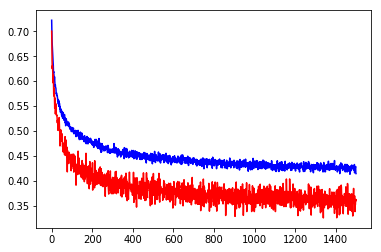

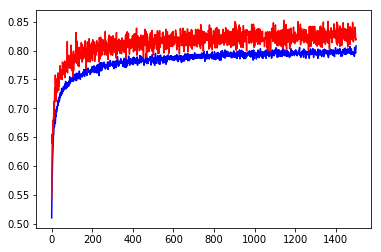

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [20]:
loss, acc = model.evaluate_generator(val_sequence, steps=100)
print(loss, acc)

0.35226036332547667 0.839375


In [21]:
acc10000 = int(acc*10000)
if acc10000 == 10000:
    run_name_acc = '%s_%05d' % (run_name, acc10000)
else:
    run_name_acc = '%s_%04d' % (run_name, acc10000)
print(run_name_acc)

Google-LandMark-Rec2019_3-Image-Similar-FCNN-Binary_20190511-164020_8393


In [22]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigths_file = os.path.join(modelPath, run_name + '.h5')
    print(weigths_file)
    model.save(weigths_file)
saveModel(model, run_name_acc)

/data/landmark-recognition-2019/model/Google-LandMark-Rec2019_3-Image-Similar-FCNN-Binary_20190511-164020_8393.h5


In [23]:
print('Time elapsed: %.1fs' % (time.time() - t0))
print(run_name_acc)

Time elapsed: 32147.5s
Google-LandMark-Rec2019_3-Image-Similar-FCNN-Binary_20190511-164020_8393
